### Analysis step

### 1. Critical Environmental Indicator Search （CEIS）

In [1]:
# Load File Path
phen_file_path = "./dataset/trainset/Pheno/"
env_file_path = "./dataset/trainset/Env/"
geno_file_path = "./dataset/trainset/Geno/YI_Main.vcf"
ref_path = "./docs/maizeRef(ALL).csv"
file_names = ["DEH1_2020", "DEH1_2021", "IAH2_2021", "IAH3_2021", "IAH4_2021", "WIH2_2020", "WIH2_2021"]

In [7]:
import pandas as pd
from autogs.data import datautils
functions = [func for func in dir(datautils) if callable(getattr(datautils, func))]
print(functions)

['combine_phenotype_data', 'fusion_PGE_data', 'process_data', 'process_environment_data', 'process_genotypic_data']


In [17]:
# Pheno data process
phen_file_path = "./dataset/trainset/Pheno/"
file_names = ["DEH1_2020", "DEH1_2021", "IAH2_2021", "IAH3_2021", "IAH4_2021", "WIH2_2020", "WIH2_2021"]
com_phen_data = datautils.combine_phenotype_data(file_path=phen_file_path,file_names=file_names)

# Extracting data for each environment
env_dataframes = [com_phen_data[com_phen_data['Env'] == env].reset_index(drop=True) for env in com_phen_data['Env'].unique()]

# Calculate the mean value for each environment
avg_values = []
for env_df in env_dataframes:
    avg_values.append([env_df['Pollen_DAP_days'].mean(),
                      env_df['Silk_DAP_days'].mean(),
                      env_df['Plant_Height_cm'].mean(),
                      env_df['Yield_Mg_ha'].mean(),
                      env_df['Grain_Moisture'].mean(),
                      env_df['Twt_kg_m3'].mean()])

phen_avg_values = pd.DataFrame(avg_values, columns=['Pollen_DAP_days', 'Silk_DAP_days', 'Plant_Height_cm', 
                                               'Yield_Mg_ha', 'Grain_Moisture', 'Twt_kg_m3'])

phen_avg_values.insert(0, 'Env', com_phen_data['Env'].unique())

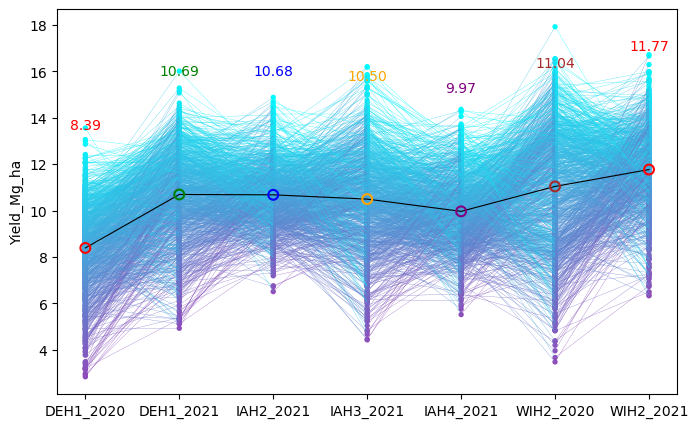

In [16]:
# plot GxE
from autogs.data import GxE
save_file = './Result/'
GxE.GxE_Plot(data=com_phen_data ,value_column='Yield_Mg_ha',save_file=save_file)

In [22]:
#  Env data process
from autogs.data import WindCode
from autogs.data import EnvAvgCal
from autogs.data import datautils
from autogs.data import cal_slope_inter

env_file_path = "./dataset/trainset/Env/"
ref_path = "./docs/maizeRef(ALL).csv"
file_names = ["DEH1_2020", "DEH1_2021", "IAH2_2021", "IAH3_2021", "IAH4_2021", "WIH2_2020", "WIH2_2021"]
com_env_data, dynamic_window_avg, env_transformed_data = datautils.process_environment_data(file_path=env_file_path,file_names=file_names,ref_path=ref_path)

In [24]:
'''
Correlations were counted using phenotypic means for each environment 
and dynamic sliding window means for each environmental metric (both dynamic and sliding window included). 
Plant height and flowering period were not included in the R period.
'''
Wind_corr_path = './Wincorr/'
# Specify the starting index position as 4
WCCorrCal = WindCode.CorrCal(phen_avg_values, dynamic_window_avg, start_index=4, save_path=Wind_corr_path)

# sliding window
growth_period = (1, 36)
sliding_window_corr = WCCorrCal.sliding_window_corr(k=1,n=36, growth_period=growth_period)

# dynamic window
# dynamic_window_corr = calculator.dynamic_window_corr() 

# Select the window with the highest correlation and calculate the mean of each environmental factor under that window     
EnvCorr_path = './Wincorr/'
max_corr_path = './Wincorr/'

EnvAvgCGPS = EnvAvgCal.CGPS(EnvCorr_path)
max_corr_results = EnvAvgCGPS.max_corr()
max_corr_env_avg = EnvAvgCGPS.EnvAvgCGP(dynamic_window_avg, max_corr_results)
max_corr_env_avg.to_csv(max_corr_path+"max_corr_env_avgV.csv")

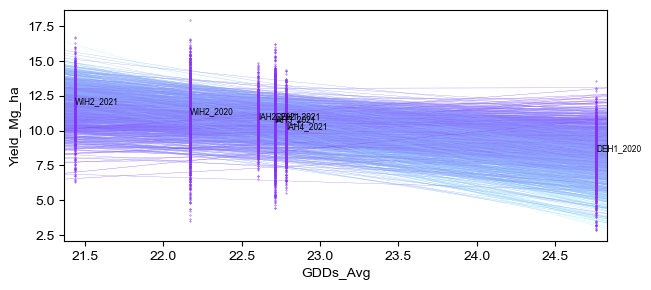

In [30]:
'''
The hybrid names were used as column names to construct a new phenotypic data
structure and with the transformed environmental data, which were used to calculate
the linear coefficients, K, and intercepts, B, of each hybrid with respect to the mean values of the environmental factors.
'''
# Extracting unique hybrids and environments
hybrids = com_phen_data['Hybrid'].unique()
environments = com_phen_data['Env'].unique()

# Initializing a dictionary to store the new data
trans_phen_data = {'Env': [], 'Phenotype': []}
for hybrid in hybrids:
    trans_phen_data[hybrid] = []

# Populating the dictionary with data
for env in environments:
    env_data = com_phen_data[com_phen_data['Env'] == env]
    trans_phen_data['Env'].append(env)
    trans_phen_data['Phenotype'].append('Yield_Mg_ha')

    for hybrid in hybrids:
        # Extracting the phenotype value for each hybrid in the environment
        phenotype_value = env_data[env_data['Hybrid'] == hybrid]['Yield_Mg_ha'].iloc[0] if not env_data[env_data['Hybrid'] == hybrid].empty else None
        trans_phen_data[hybrid].append(phenotype_value)

# Creating a new DataFrame
new_phen_data = pd.DataFrame(trans_phen_data)

# Calculate slopes and intercepts
# Calculation of slopes and intercepts requires max_corr_env_avg, new_phen_data of the above calculations,env_index name and phenotype name.
result_path='./Wincorr/'
slopes, intercepts = cal_slope_inter.slope_inter(env_df=max_corr_env_avg, phenotype_df=new_phen_data,\
                                                 env_index='GDDs_Avg', phenotype='Yield_Mg_ha',result_path=result_path)

### 2. GWAS analysis using slope and intercept for QTL screening

In [ ]:
'''
This step entails GWAS analysis using the above calculated slopes, intercepts, and raw SNPs to screen for QTL.
After obtaining the QTL perform the following genome prediction steps
'''

### 3.Genome prediction

In [39]:
import os
import sys
import pprint
import sklearn
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from autogs.data.tools.reg_metrics import (mae_score as mae,
                             mse_score as mse,
                             rmse_score as rmse,
                             r2_score as r2,
                             rmsle_score as rmsle,
                             mape_score as mape,
                             medae_score as medae,
                             pcc_score as pcc)

from autogs.model import RegAutoGS
from autogs.data import datautils

# Read data
phen_file_path = "./test/dataset/trainset/Pheno/"
env_file_path = "./test/dataset/trainset/Env/"
geno_file_path = "./test/dataset/trainset/Geno/YI_All.vcf"
ref_path = "./test/docs/maizeRef_ALL.csv"
file_names = ["DEH1_2020", "DEH1_2021", "IAH2_2021", "IAH3_2021", "IAH4_2021", "WIH2_2020", "WIH2_2021"]

com_phen_data, com_env_data, dynamic_window_avg, env_transformed_data, \
gendata, PGE = datautils.process_data(phen_file_path, env_file_path, geno_file_path, ref_path, file_names)

# Access to phenotype （Yield_Mg_ha） and feature data （Gneo and Env）
columns_to_extract = [0, 1, 8] # Get Columns Env, Hybrid, and Yield_Mg_ha

columns_from_11_to_end = list(range(11, PGE.shape[1])) 
columns_indices = columns_to_extract + columns_from_11_to_end
extracted_columns = PGE.iloc[:, columns_indices]
extracted_columns = pd.DataFrame(extracted_columns.dropna().reset_index(drop=True))

snp = pd.DataFrame(extracted_columns.iloc[:,3:])
scaler = StandardScaler()
scaled_snp = scaler.fit_transform(snp)
X = pd.DataFrame(scaled_snp,columns=snp.columns)
y = extracted_columns['Yield_Mg_ha']
y = pd.core.series.Series(y)

# train AutoGS model for reg prediction
reg = RegAutoGS(
    y=y,
    X=X, 
    test_size=0.2, 
    n_splits=5, 
    n_trial=5, 
    reload_study=True,
    reload_trial=True, 
    write_folder=os.getcwd()+'/results/', 
    metric_optimise=r2, 
    metric_assess=[mae, mse, rmse, pcc, r2, rmsle, mape, medae],
    optimization_objective='maximize', 
    models_optimize=['LightGBM','XGBoost','CatBoost','BayesianRidge'], 
    models_assess=['LightGBM','XGBoost','CatBoost','BayesianRidge'], 
    early_stopping_rounds=5, 
    random_state=2024
)
reg.train() # train model
# reg.CalSHAP(n_train_points=200,n_test_points=200,cluster=False) # cal SHAP value

[I 2025-02-13 21:01:03,321] A new study created in RDB with name: regression_LightGBM
[I 2025-02-13 21:01:07,738] Trial 0 finished with value: 0.3613729474149356 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 6, 'n_estimators': 73, 'max_bin': 63, 'min_gain_to_split': 11.288975058128688, 'lambda_l1': 0.002642632982436118, 'lambda_l2': 4.528956796258575, 'num_leaves': 171, 'feature_fraction': 0.6459666573868087, 'bagging_fraction': 0.5042361834385448, 'bagging_freq': 2, 'min_child_samples': 68, 'random_state': 2024, 'verbosity': -1, 'transformers': None}. Best is trial 0 with value: 0.3613729474149356.
[I 2025-02-13 21:01:25,509] Trial 1 finished with value: 0.3691728335110588 and parameters: {'scaler': 'minmax', 'objective': 'regression', 'max_depth': 16, 'n_estimators': 947, 'max_bin': 1023, 'min_gain_to_split': 3.584802486535936, 'lambda_l1': 8.699521020920383e-05, 'lambda_l2': 0.8950521188217407, 'num_leaves': 75, 'feature_fraction': 0.8060561713786789, 


🔍 Model: LightGBM_best
--------------------------------------------------
  Fold 1:
    pearson_correlation      : 0.6468
    root_mean_squared_error  : 1.4905
  Fold 2:
    pearson_correlation      : 0.5721
    root_mean_squared_error  : 1.7021
  Fold 3:
    pearson_correlation      : 0.4946
    root_mean_squared_error  : 1.9048
  Fold 4:
    pearson_correlation      : 0.6980
    root_mean_squared_error  : 1.6785
  Fold 5:
    pearson_correlation      : 0.5950
    root_mean_squared_error  : 1.6200

  Summary for LightGBM_best:
    pearson_correlation      : 0.6013 ± 0.0688 ✅
    root_mean_squared_error  : 1.6792 ± 0.1346 ✅

🔍 Model: XGBoost_best
--------------------------------------------------
  Fold 1:
    pearson_correlation      : 0.5559
    root_mean_squared_error  : 1.6905
  Fold 2:
    pearson_correlation      : 0.5025
    root_mean_squared_error  : 1.8599
  Fold 3:
    pearson_correlation      : 0.4913
    root_mean_squared_error  : 1.9584
  Fold 4:
    pearson_correlation  